# **Modified Demo notebook for Computer aided detection with Faster-RCNN 
### Source from https://github.com/riblidezso/frcnn_cad
Based on code and model from Ribli et. al., [Computer aided detection with Faster-RCNN](https://github.com/riblidezso/frcnn_cad). The output of the images here are located in the repo folder `post_images/`

### Prerequisites

* You need to install py-faster-rcnn, see the github repository for instructions: https://github.com/rbgirshick/py-faster-rcnn

* You need a GPU with at least 8GB memory, with CUDA and cuDNN

### Import modules and change Faster-RCNN configs
Make sure to change the path to the `tools/` folder of your py-faster-rcnn installation.

In [2]:
import sys
# here is my py-faster-rcnn installation
sys.path.append('/opt/py-faster-rcnn/tools/')  
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
import caffe, cv2
import pathlib
# faster rcnn configs we need to change
cfg.TEST.HAS_RPN = True  # Use RPN for proposals
cfg.TEST.SCALES=(1737,)
cfg.TEST.MAX_SIZE=2145
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Define functions to load model, run detection, and visualize detection

In [3]:
def load_net(ptxt, w, device=0):
    """Load model."""
    caffe.set_mode_gpu()
    caffe.set_device(device)
    cfg.GPU_ID = device
    net = caffe.Net(ptxt, w, caffe.TEST)
    return net


def detect(net, im,  NMS_THRESH = 0.1, cls_ind = 2,
           CLASSES = ('__background__','BENIGN','MALIGNANT')):
    """Detect cancer."""
    cfg.TEST.HAS_RPN = True
    scores, boxes =  im_detect(net, im)
    #print(scores.shape)
    #scores = R x K where K is object class scores 
    #boxes = Rx (4*K) array of predicted bounding boxes
    
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                        cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH) #nonmaximum suppression
    dets = dets[keep, :]
    return dets


def vis_detections(im, dets, CONF_THRESH = 0.23, compressed=False):
    """Draw boxes around detected cancer."""   
    fig,ax=plt.subplots(figsize=(8,10))
    ax.imshow(im,cmap='gray_r')
    inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    scores_only = [0]
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        if not compressed:
            print("Lesion {}".format(i+1))
            print("Confidence of class as malignant: {}".format(score))
            print("Locations: Top left coordinate: {}, {} \n".format(bbox[0], bbox[1]))
        else:
            print("Lesion {0}, Malignant {1}".format(i+1, score))
        ax.add_patch(
            
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False, linestyle ='dashed',
                          edgecolor=(0.95, 0.95, 0.5), linewidth=3))
        plt.text(bbox[0], bbox[1], str(i+1), fontsize=15, color="red")
        scores_only.append(score)
        
    #plt.axis('off') #Turning axis on/off
    plt.tight_layout()
    plt.show()
    return fig, scores_only 

In [20]:
def predictions(currentFile, thresh=0.01, compressed=False):
    '''
    Arguments:
        currentFile (string or Posix path) - path to image
        thresh - lowest malignancy confidence score algorithm will detect the image.
        compressed - if True, will show the top left coordinate of the bounding box. If False, will only show scores. 
    '''
    currentFile = pathlib.Path(currentFile)
    test_img = cv2.imread(str(currentFile))
    print(currentFile.name)
    print(type(test_img))
    print(test_img.shape)
    # run detection
    test_detections = detect(net, test_img, cls_ind=2)
    # visualize detections
    fig, scores_only = vis_detections(test_img, test_detections, CONF_THRESH=thresh, compressed=compressed)
    return fig, scores_only

### Load the model

In [5]:
# place the model weights here
net = load_net(ptxt='vgg16_frcnn_cad_test.prototxt',
               w='vgg16_frcnn_cad.caffemodel')

### Testing the model
Change the path below to path for images.

In [21]:
path = pathlib.Path('/home/mqian/projects/cadt/cluster_generation_frcnn_cad/post_images')

#### For one image.

prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1
Confidence of class as malignant: 0.621653258801
Locations: Top left coordinate: 928.204162598, 104.878715515 

Lesion 2
Confidence of class as malignant: 0.530176818371
Locations: Top left coordinate: 1855.49438477, 112.282676697 

Lesion 3
Confidence of class as malignant: 0.51326328516
Locations: Top left coordinate: 1517.62243652, 68.7282333374 

Lesion 4
Confidence of class as malignant: 0.508521258831
Locations: Top left coordinate: 1827.26782227, 442.668823242 

Lesion 5
Confidence of class as malignant: 0.487994968891
Locations: Top left coordinate: 1172.26330566, 443.268554688 

Lesion 6
Confidence of class as malignant: 0.46975544095
Locations: Top left coordinate: 937.588256836, 810.194091797 

Lesion 7
Confidence of class as malignant: 0.458917140961
Locations: Top left coordinate: 1540.26904297, 465.916625977 

Lesion 8
Confidence of class as malignant: 0.42240664

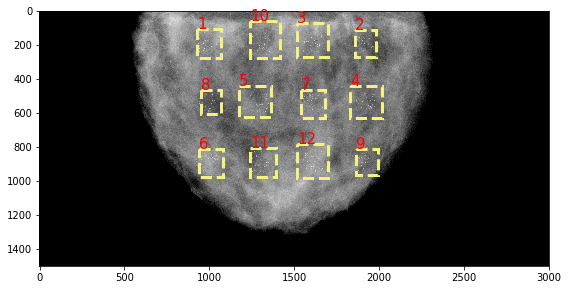

(<Figure size 576x720 with 1 Axes>,
 [0,
  0.62165326,
  0.53017682,
  0.51326329,
  0.50852126,
  0.48799497,
  0.46975544,
  0.45891714,
  0.42240664,
  0.39500982,
  0.38406372,
  0.34403181,
  0.27826148])

In [22]:
predictions(path/'prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png', thresh=0.23)

#### For multiple images

prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1, Malignant 0.621653258801
Lesion 2, Malignant 0.530176818371
Lesion 3, Malignant 0.51326328516
Lesion 4, Malignant 0.508521258831
Lesion 5, Malignant 0.487994968891
Lesion 6, Malignant 0.46975544095
Lesion 7, Malignant 0.458917140961
Lesion 8, Malignant 0.422406643629
Lesion 9, Malignant 0.395009815693
Lesion 10, Malignant 0.384063720703
Lesion 11, Malignant 0.34403181076
Lesion 12, Malignant 0.278261482716
Lesion 13, Malignant 0.0582184568048
Lesion 14, Malignant 0.0287216566503
Lesion 15, Malignant 0.0178502053022


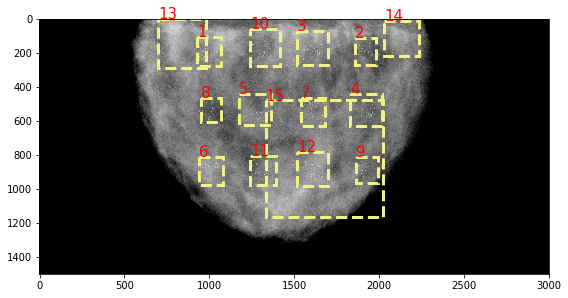

prj_30mm_2_cluster_phantom_285_40nm_m_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1, Malignant 0.279183954
Lesion 2, Malignant 0.233635172248
Lesion 3, Malignant 0.209760412574
Lesion 4, Malignant 0.199735373259
Lesion 5, Malignant 0.19260841608
Lesion 6, Malignant 0.126115813851
Lesion 7, Malignant 0.0953410491347
Lesion 8, Malignant 0.0611260682344
Lesion 9, Malignant 0.058834284544
Lesion 10, Malignant 0.0468995422125
Lesion 11, Malignant 0.0398289039731
Lesion 12, Malignant 0.0165712796152
Lesion 13, Malignant 0.0138078751042
Lesion 14, Malignant 0.0128598231822
Lesion 15, Malignant 0.0110328532755


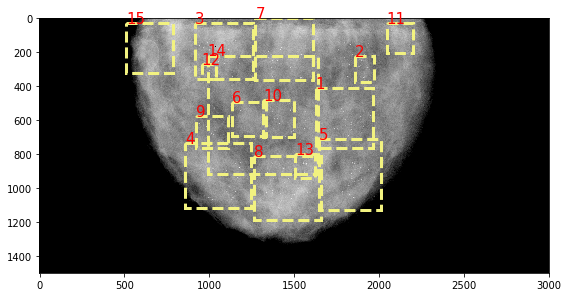

prj_30mm_2_cluster_phantom_71_40nm_m_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1, Malignant 0.20591956377
Lesion 2, Malignant 0.199620172381
Lesion 3, Malignant 0.177939772606
Lesion 4, Malignant 0.15922626853
Lesion 5, Malignant 0.122961886227
Lesion 6, Malignant 0.121997386217
Lesion 7, Malignant 0.112830325961
Lesion 8, Malignant 0.10375187546
Lesion 9, Malignant 0.10095910728
Lesion 10, Malignant 0.0804292708635
Lesion 11, Malignant 0.0635282322764
Lesion 12, Malignant 0.0575972758234
Lesion 13, Malignant 0.0466020703316
Lesion 14, Malignant 0.0462350994349
Lesion 15, Malignant 0.0451687127352
Lesion 16, Malignant 0.0325251556933
Lesion 17, Malignant 0.0295696221292
Lesion 18, Malignant 0.0259940382093
Lesion 19, Malignant 0.0249340869486
Lesion 20, Malignant 0.0167793054134
Lesion 21, Malignant 0.0127987070009
Lesion 22, Malignant 0.0101079186425


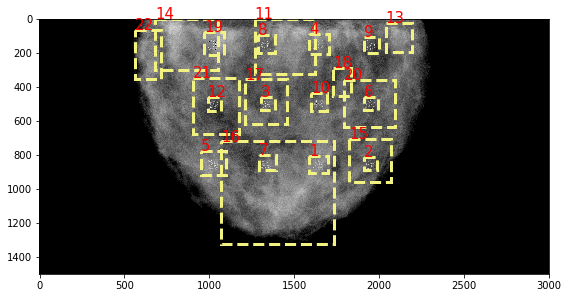

In [19]:
names = ['prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png',
    'prj_30mm_2_cluster_phantom_285_40nm_m_full_0.7_25.raw.gz.raw.png',
    'prj_30mm_2_cluster_phantom_71_40nm_m_full_0.7_25.raw.gz.raw.png']

for name in names:
    predictions(path/name, thresh=0.01, compressed=True)

#### For all images in a folder.

prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1
Confidence of class as malignant: 0.621653258801
Locations: Top left coordinate: 928.204162598, 104.878715515 

Lesion 2
Confidence of class as malignant: 0.530176818371
Locations: Top left coordinate: 1855.49438477, 112.282676697 

Lesion 3
Confidence of class as malignant: 0.51326328516
Locations: Top left coordinate: 1517.62243652, 68.7282333374 

Lesion 4
Confidence of class as malignant: 0.508521258831
Locations: Top left coordinate: 1827.26782227, 442.668823242 

Lesion 5
Confidence of class as malignant: 0.487994968891
Locations: Top left coordinate: 1172.26330566, 443.268554688 

Lesion 6
Confidence of class as malignant: 0.46975544095
Locations: Top left coordinate: 937.588256836, 810.194091797 

Lesion 7
Confidence of class as malignant: 0.458917140961
Locations: Top left coordinate: 1540.26904297, 465.916625977 

Lesion 8
Confidence of class as malignant: 0.42240664

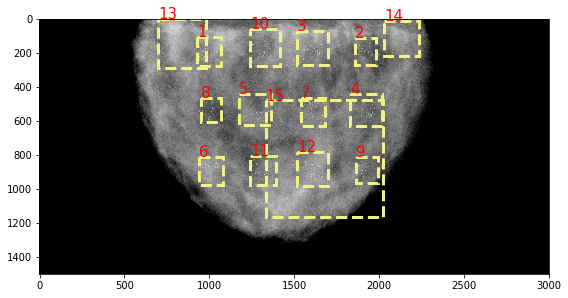

prj_30mm_2_cluster_phantom_285_40nm_m_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1
Confidence of class as malignant: 0.279183954
Locations: Top left coordinate: 1626.02893066, 412.316436768 

Lesion 2
Confidence of class as malignant: 0.233635172248
Locations: Top left coordinate: 1858.30029297, 223.378463745 

Lesion 3
Confidence of class as malignant: 0.209760412574
Locations: Top left coordinate: 917.255554199, 29.8830413818 

Lesion 4
Confidence of class as malignant: 0.199735373259
Locations: Top left coordinate: 857.595214844, 735.8359375 

Lesion 5
Confidence of class as malignant: 0.19260841608
Locations: Top left coordinate: 1645.6932373, 713.643615723 

Lesion 6
Confidence of class as malignant: 0.126115813851
Locations: Top left coordinate: 1132.55664062, 495.174194336 

Lesion 7
Confidence of class as malignant: 0.0953410491347
Locations: Top left coordinate: 1270.14367676, 1.66836547852 

Lesion 8
Confidence of class as malignant: 0.0611260682

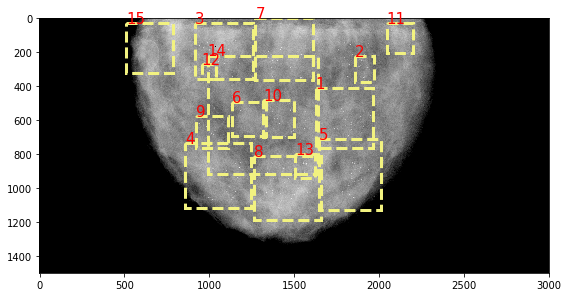

prj_30mm_2_cluster_phantom_71_40nm_m_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1
Confidence of class as malignant: 0.20591956377
Locations: Top left coordinate: 1588.64331055, 805.500549316 

Lesion 2
Confidence of class as malignant: 0.199620172381
Locations: Top left coordinate: 1909.36706543, 814.121337891 

Lesion 3
Confidence of class as malignant: 0.177939772606
Locations: Top left coordinate: 1302.83422852, 457.147521973 

Lesion 4
Confidence of class as malignant: 0.15922626853
Locations: Top left coordinate: 1585.88366699, 88.1269454956 

Lesion 5
Confidence of class as malignant: 0.122961886227
Locations: Top left coordinate: 951.298583984, 776.89465332 

Lesion 6
Confidence of class as malignant: 0.121997386217
Locations: Top left coordinate: 1908.72045898, 460.616424561 

Lesion 7
Confidence of class as malignant: 0.112830325961
Locations: Top left coordinate: 1293.4486084, 801.865112305 

Lesion 8
Confidence of class as malignant: 0.103751875

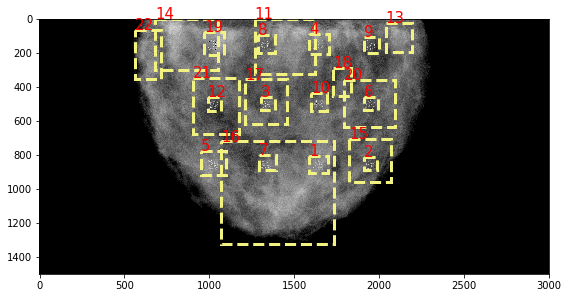

In [23]:
for currentFile in path.iterdir():
    if currentFile.suffix == '.png':
        predictions(currentFile, thresh=0.01)

#### For all images in a folder but stopping at each image. 
Enter specific malignancy scores. Must list more than one index, and must be separated by numbers (i.e. `1, 2, 3, 5`).

prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1, Malignant 0.621653258801
Lesion 2, Malignant 0.530176818371
Lesion 3, Malignant 0.51326328516
Lesion 4, Malignant 0.508521258831
Lesion 5, Malignant 0.487994968891
Lesion 6, Malignant 0.46975544095
Lesion 7, Malignant 0.458917140961
Lesion 8, Malignant 0.422406643629
Lesion 9, Malignant 0.395009815693
Lesion 10, Malignant 0.384063720703
Lesion 11, Malignant 0.34403181076
Lesion 12, Malignant 0.278261482716
Lesion 13, Malignant 0.0582184568048


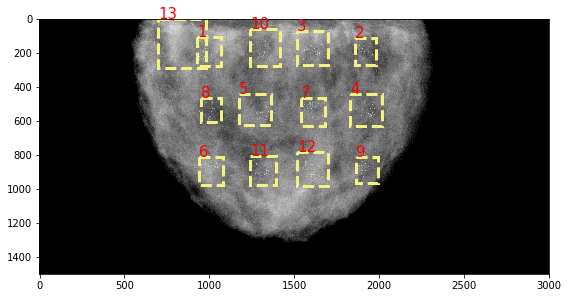

prj_30mm_2_cluster_phantom_142_40nm_full_0.7_25.raw.gz.raw.png
Which indexes? List them separated by commas: 1, 10, 3, 2
['1', '10', '3', '2']
0.621653
0.384064
0.513263
0.530177
Continue? Please type a number4
prj_30mm_2_cluster_phantom_285_40nm_m_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1, Malignant 0.279183954
Lesion 2, Malignant 0.233635172248
Lesion 3, Malignant 0.209760412574
Lesion 4, Malignant 0.199735373259
Lesion 5, Malignant 0.19260841608
Lesion 6, Malignant 0.126115813851
Lesion 7, Malignant 0.0953410491347
Lesion 8, Malignant 0.0611260682344
Lesion 9, Malignant 0.058834284544


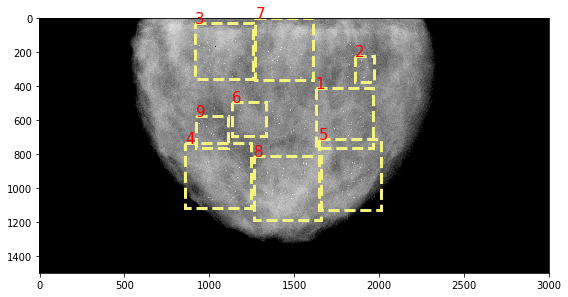

prj_30mm_2_cluster_phantom_285_40nm_m_full_0.7_25.raw.gz.raw.png
Which indexes? List them separated by commas: 3, 7
['3', '7']
0.20976
0.095341
Continue? Please type a number4
prj_30mm_2_cluster_phantom_71_40nm_m_full_0.7_25.raw.gz.raw.png
<type 'numpy.ndarray'>
(1500, 3000, 3)
Lesion 1, Malignant 0.20591956377
Lesion 2, Malignant 0.199620172381
Lesion 3, Malignant 0.177939772606
Lesion 4, Malignant 0.15922626853
Lesion 5, Malignant 0.122961886227
Lesion 6, Malignant 0.121997386217
Lesion 7, Malignant 0.112830325961
Lesion 8, Malignant 0.10375187546
Lesion 9, Malignant 0.10095910728
Lesion 10, Malignant 0.0804292708635
Lesion 11, Malignant 0.0635282322764
Lesion 12, Malignant 0.0575972758234


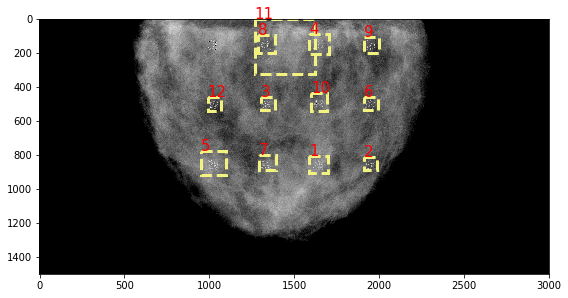

prj_30mm_2_cluster_phantom_71_40nm_m_full_0.7_25.raw.gz.raw.png
Which indexes? List them separated by commas: 5, 7, 1, 2
['5', '7', '1', '2']
0.122962
0.11283
0.20592
0.19962
Continue? Please type a number4


In [25]:
for currentFile in path.iterdir():
    #Here, can insert a substring inside specific file names to only output images with specific parameters.
    if currentFile.suffix == '.png' and '' in currentFile.name:
        _, scores = predictions(currentFile, thresh=0.05, compressed=True)
        print(currentFile.name)
        index = str(input('Which indexes? List them separated by commas: '))[1:-1].split(", ")
        print(index)
        scores_p = [scores[int(i)] for i in index]
        print("\n".join(str(x) for x in scores_p))
        x = str(input('Continue? Please type a number'))

### That's it

The example image is from the INBreast dataset. Courtesy of the Breast Research Group, INESC Porto, Portugal. Thank you.